# IN4080: obligatory assignment 2 (Autumn 2025)

Mandatory assignment 2 consists of three parts. In Part 1, you will experiment with a greedy sequence labeling model and investigate the impact of different feature types on **part-of-speech tagging** performance (9 points + 2 optional bonus points). In Part 2, you will evaluate the best model on a different task, **named entity recognition** (5 points). In Part 3, you will return to the **text classification task** and implement a simple feed-forward neural network for it (6 points).

You should answer all three parts. You are required to get at least 12/20 points to pass. The most important is that you try to answer each question (possibly with some mistakes), to help you gain a better and more concrete understanding of the topics covered during the lectures. In the first part, there are also bonus questions for those of you who would like to deepen their understanding of the topics covered by this assignment.

- We assume that you have read and are familiar with IFI’s requirements and guidelines for mandatory assignments, see [here](https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html) and [here](https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-guidelines.html).
- This is an individual assignment. You should not deliver joint submissions.
- You may redeliver in Devilry before the deadline (__Friday, October 3 at 23:59__), but include all files in the last delivery.
- Only the last delivery will be read! If you deliver more than one file, put them into a zip-archive. You don't have to include in your delivery the files already provided for this assignment.
- Name your submission _your\_username\_in4080\_mandatory\_2_
- You can work on this assignment either on the IFI machines or on your own computer.

*The preferred format for the assignment is a completed version of this Jupyter notebook*, containing both your code and explanations about the steps you followed. We want to stress that simply submitting code is __not__ by itself sufficient to complete the assignment - we expect the notebook to also contain explanations of what you have implemented, along with motivations for the choices you made along the way. Preferably use whole sentences, and mathematical formulas if necessary. Explaining in your own words (using concepts we have covered through in the lectures) what you have done and reflecting on your solution is an important part of the learning process - take it seriously!

Regarding the use of LLMs (ChatGPT or similar): you are allowed to use them as 'sparring partner', for instance to clarify something you have not understood. However, you are __not__ allowed to use them to generate solutions (either in part or in full) to the assignment tasks. If you are using code editors such as VS Code, you should make sure that code completion plugins such as Copilot are disabled when working on the assignment.

In this assignment, we'll use the following Python modules: `scikit-learn, pyconll, matplotlib, sentence_transformers`. Make sure you have installed them.

In [2]:
# if you use a virtual environment, you can install the modules like this
%pip install scikit-learn pyconll matplotlib sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 15.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformersm━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [tokenizers]
    Found existing installation: transformers 2.1.1━━━━━━━━━━━ 1/4 [tokenizers]
    Uninstalling transformers-2.1.1:━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [tokenizers]
      Successfully uninstalled transformers-2.1.1━━━━━━━━━━━━━ 1/4 [tokenizers]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [sentence_transformers]ence_transformers]
Note: you may need to restart the kernel to use updated packages.


If you use Fox, make sure to load the following modules (we will not use `pyconll` in this case):

* nlpl-sentence-transformers/3.1.1-foss-2022b-Python-3.10.8
* nlpl-transformers/4.47.1-foss-2022b-Python-3.10.8
* nlpl-llmtools/06-foss-2022b-Python-3.10.8
* nlpl-nlptools/04-foss-2022b-Python-3.10.8

## Part 1 – Greedy logistic regression taggers and feature engineering

In the lecture, we have discussed Matthew Honnibal's proposal of a discriminative sequence labelling model with greedy decoding. He argued that an extended set of features is more helpful for tagging than exact (Viterbi) decoding. Therefore, we skip HMMs and the Viterbi algorithm here and focus on models based on logistic regression.

Scikit-learn doesn't contain implementations of sequence labeling models. Therefore, we provide you with some basic code. The code below defines a `GreedyTagger` with a `fit()` function for training and a `predict()` function for prediction/testing. By default, it uses a standard Scikit-learn logistic regression classifier under the hood, which takes a feature vector for a word (and its context) as input and provides the most likely class label as output.

Your task in this part will mainly consist in defining how a word (and its context) is converted to a feature vector.

In [3]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer


class GreedyTagger:
    """
    Tagger based on logistic regression or any other classification algorithm supported by Scikit-Learn.
    """

    def __init__(
        self,
        feature_function,
        classifier=LogisticRegression(solver="saga", max_iter=500, tol=0.001),
    ):
        """
        Creates a GreedyTagger object.

        Args:
            feature_function: A function that transforms the input sequence and the index of the current word into a set of key-value pairs.
            classifier: A Scikit-Learn classifier instance.
        """
        self.features = feature_function
        self.classifier = classifier
        self.vectorizer = DictVectorizer()
        self.label_ids = {}  # mapping from labels to numeric label ids
        self.id_labels = {}  # mapping from numeric label ids to labels

    def fit(self, dataset_X, dataset_Y):
        """
        Trains the tagger. Creates a list of inputs (feature vectors of individual words) and a list of labels (numeric ids) and calls the `fit` function of the base classifier on these lists.

        Args:
            dataset_X: The input training data, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of tokens.
            dataset_Y: The training data labels, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of labels (e.g. POS-tags or BIO-tags).
        """
        flattened_dataset_X = []  # a flat list of training instances
        flattened_dataset_Y = []  # a flat list of label ids for the training instances
        for sentence_X, sentence_Y in zip(dataset_X, dataset_Y):
            # sentence_X is a list of words
            # sentence_Y is a list of labels, one for each word of the sentence
            history = []
            for i, (x, y) in enumerate(zip(sentence_X, sentence_Y)):
                feature_dict = self.features(sentence_X, i, history)
                flattened_dataset_X.append(feature_dict)
                if y not in self.label_ids:
                    self.label_ids[y] = len(self.label_ids)
                flattened_dataset_Y.append(self.label_ids[y])
                history.append(y)
        transformed_dataset_X = self.vectorizer.fit_transform(flattened_dataset_X)
        transformed_dataset_Y = np.array(flattened_dataset_Y)
        self.id_labels = {self.label_ids[label]: label for label in self.label_ids}
        self.classifier.fit(transformed_dataset_X, transformed_dataset_Y)
        return self

    def predict(self, dataset_X):
        """
        Predicts the labels for the input data, sentence by sentence.

        Args:
            dataset_X: The input training data, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of tokens.

        Returns:
            list: The predicted labels, in the same format as dataset_X (list of lists).
        """
        predictions = []
        for sentence_X in dataset_X:
            flattened_sentence_X = []
            history = []
            for i, word in enumerate(sentence_X):
                feature_dict = self.features(sentence_X, i, history)
                flattened_sentence_X.append(feature_dict)
            transformed_sentence_X = self.vectorizer.transform(flattened_sentence_X)
            predicted_sentence_Y = self.classifier.predict(transformed_sentence_X)
            predicted_labels_Y = [self.id_labels[y] for y in predicted_sentence_Y]
            predictions.append(predicted_labels_Y)
        return predictions

When instantiating this class, you need to provide a so-called *feature function* that defines how the feature vector is created. In the provided implementation, this is done in two steps:
1. The feature function creates a feature dictionary. Each key of the dictionary defines a one-hot vector, and the value determines which value of the vector will be set to one. For example, the feature dictionary `{"curr_word": "love", "prev_word": "I", "next_word": "fish"}` defines three one-hot vectors, which together represent the word `love` in the sequence `I love fish`. The keys can be chosen freely.
2. The `DictVectorizer` class of Scikit-Learn will convert the feature dictionary to actual one-hot vectors and concatenate them into a single vector. This step is already taken care of in the `fit()` function.

A basic feature function that only uses the current word could look like this (we will use the parameter `history` later, but don't worry about it now):

In [ ]:
def basic_features(sentence, i, history):
    features = {"curr_word": sentence[i]}
    return features

The `predict()` function only returns the predicted labels, it doesn't compare them to the ground truth. Here is another function that computes accuracy for the predictions of a dataset. However, the function is incomplete -- it only uses the first sentence of the dataset.

**Task 1.1** (1 point): Modify the function to take into account all sentences of the dataset. The easiest way to achieve this is to flatten a list of lists into a single list, so you'll only have to call the `accuracy_score` function once.

In [10]:
def tagging_accuracy(dataset_Y_true, dataset_Y_pred):
    ## CHANGE CODE HERE
    # flatten a list of lists 
    words_Y_true = [y for sentence in dataset_Y_true for y in sentence]
    words_Y_pred = [y for sentence in dataset_Y_pred for y in sentence]
    assert len(words_Y_true) == len(words_Y_pred) # check if they have the same length 
    acc = sklearn.metrics.accuracy_score(words_Y_true, words_Y_pred)
    return acc

Finally, we need some actual data to work with. We provide you with part-of-speech annotated data for Norwegian Bokmål taken from (https://universaldependencies.org/).

There are two ways of loading the data here:

1. You can use the `pyconll` library


In [6]:
import pyconll


def load_data_from_conllu(filename):
    data = pyconll.load_from_file(filename)
    X, Y = [], []
    for sentence in data:
        X.append(
            [token.form for token in sentence]
        )  # the "form" field contains the words
        Y.append(
            [token.upos for token in sentence]
        )  # the "upos" field contains the part-of-speech tags in universal POS format
    print(f"{len(X)} sentences loaded from file {filename}")
    return X, Y


train_data_x, train_data_y = load_data_from_conllu("no_bokmaal-ud-train.conllu")
valid_data_x, valid_data_y = load_data_from_conllu("no_bokmaal-ud-dev.conllu")
test_data_x, test_data_y = load_data_from_conllu("no_bokmaal-ud-test.conllu")

15696 sentences loaded from file no_bokmaal-ud-train.conllu
2409 sentences loaded from file no_bokmaal-ud-dev.conllu
1939 sentences loaded from file no_bokmaal-ud-test.conllu


2. You can use our preprocessed `.conllu` files, which are saved as `.json` files

In [ ]:
import json


def load_data_from_json(filename):
    with open(filename, "r", encoding="utf-8") as f:
        data = json.load(f)
    X, Y = [], []
    for sentence in data:
        X.append(sentence["sentence"])
        Y.append(sentence["labels"])
    return X, Y


train_data_x, train_data_y = load_data_from_json("no_bokmaal-ud-train.json")
valid_data_x, valid_data_y = load_data_from_json("no_bokmaal-ud-dev.json")
test_data_x, test_data_y = load_data_from_json("no_bokmaal-ud-test.json")

In any of the options, the data should look like this:

In [7]:
train_data_x[0], train_data_y[0]

(['Lam', 'og', 'piggvar', 'på', 'bryllupsmenyen'],
 ['NOUN', 'CCONJ', 'NOUN', 'ADP', 'NOUN'])

Now, we can put everything together. Let us train a tagger on the training data and evaluate it on the validation set.

**Task 1.2** (1 point): Write the corresponding code and output the accuracy (as a number between 0 and 1).

In [17]:
# instantiate the tagger
def basic_features(sentence,i, histoty):
    return {"current_word": sentence[i]}

tagger = GreedyTagger(feature_function=basic_features)

# train the tagger on the training data
tagger.fit(train_data_x, train_data_y)

#predit on the validation set
pred_validation = tagger.predict(valid_data_x)

#computing the accuracy 
acc=tagging_accuracy(valid_data_y,pred_validation)
print(acc)

0.88534191206797


**Task 1.3** (1 point): The basic feature function only looks at the current word. Also add the previous word, the next word, and the word before the previous one. Make sure to handle edge cases at the beginning and at the end of the sentence. For example, the feature dictionary for the first word of `I love fish` could look as follows: `{"curr_word": "I", "prev_word": "<START>", "prev2_word": "<START>", "next_word": "love"}` (you should still not need the parameter `history` for this). Add one feature at a time, train a model, and record the accuracy. Describe which combination of features works best.

In [12]:
def context_features(sentence, i, history):
    #define the current, previous, next and the one before previous
    curr = sentence[i]
    prev = sentence[i-1] if i-1 >= 0 else "<START>"
    prev2 = sentence[i-2] if i-2 >= 0 else "<START>"
    nextw = sentence[i+1] if i+1 < len(sentence) else "<END>"

    features = {
        "curr_word": curr,
        "prev_word": prev,
        "prev2_word": prev2,
        "next_word": nextw
    }
    return features

**Task 1.4** (1 point): Up to now, we are still using a unigram model, in the sense that no information about the *labels* at previous positions is incorporated. Let us change this now by adding so-called *transition features*. Add a key `prev_tag` to the feature function and fill it with the label of the previous position. You can use the `history` parameter for this. Write your new feature function below:

In [13]:
def transition_features(sentence, i, history):
    #define the current, previous, next and the one before previous
    curr = sentence[i]
    prev = sentence[i-1] if i-1 >= 0 else "<START>"
    prev2 = sentence[i-2] if i-2 >= 0 else "<START>"
    nextw = sentence[i+1] if i+1 < len(sentence) else "<END>"

    #incorporating previous tag
    prev_tag = history[-1] if len(history) > 0 else "<START>"
    
    features = {
        "curr_word": curr,
        "prev_word": prev,
        "prev2_word": prev2,
        "next_word": nextw,
        "prev_tag": prev_tag
    }
    return features

Before you start training the model with the transition features, have a closer look at the starter code provided at the beginning. You will notice that the `history` parameter is correctly filled in the `fit()` function, but that it always remains empty in the `predict()` function. With this setup, adding transition features will not have any impact on the accuracy. You will therefore have to implement an alternative prediction function that fixes this issue.

**Task 1.5** (2 points): Complete the `predict_with_history()` function below such that the history list is filled with the predicted label at each step. Instead of calling `self.classifier.predict()` once per sentence, you will have to call it for each word separately, because the feature vector for a given position can only be computed once the previous word has been labeled.

In [14]:
def predict_with_history(self, dataset_X):
    predictions = [] # one list of tags per sentence 
    for sentence_X in dataset_X: # loop over the sentences
        history = [] # stores the predicted labels for the current sentence
        sent_preds = [] # save the rpedicted labels for the current sentence
        for i, _ in enumerate(sentence_X): # from left to the right of the sentence toke by token
            feature = self.features(sentence_X, i, history) # build the feature dictionary for token i where the history is incorporated
            X_i = self.vectorizer.transform([feature]) # convert the dictionary to one hot encoding vector
            y_id = self.classifier.predict(X_i)[0] # using the classifier to predict id
            y = self.id_labels[y_id] # map the id back to the label
            sent_preds.append(y) # save the prediction for this token 
            history.append(y) # update the history
        predictions.append(sent_preds)
    return predictions

# attach the function to the GreedyTagger class
setattr(GreedyTagger, "predict_with_history", predict_with_history)

**Task 1.6** (1 point): Train a new tagger using the transition features and the `predict_with_history()` function. Do the transition features help? Note: The prediction will be significantly slower than before because of the modifications made above.

In [19]:
# train the tagger using transition features and the predict_with history()
tagger_trans = GreedyTagger(feature_function=transition_features)
tagger_trans.fit(train_data_x, train_data_y)
pred_trans = tagger_trans.predict_with_history(valid_data_x)
acc_trans = tagging_accuracy(valid_data_y, pred_trans)
print("Validation accuracy (with transitions):", acc_trans)

# train the tagger using context features and the predict_with history()
tagger_base = GreedyTagger(feature_function=context_features)
tagger_base.fit(train_data_x, train_data_y)
pred_base = tagger_base.predict_with_history(valid_data_x)  # history unused but fine
acc_base = tagging_accuracy(valid_data_y, pred_base)
print("Validation accuracy (no transitions):", acc_base)

#compare the differences
print("Accuracy difference:", acc_trans - acc_base)

# It seems that the transition features did not help, because the validation accuracy is higher for the prediction using the context features.
# But it helps if comparing to using the basic features, because the accuracy is higher than the acc(0.89) of using basic features. 


Validation accuracy (with transitions): 0.9181170777310347
Validation accuracy (no transitions): 0.922516428826748
Accuracy difference: -0.004399351095713322


**Task 1.7** (_optional, 2 extra points_): You may have noticed that there is a significant implementation difference between the `fit()` and `predict_with_history()` functions. During training, the `history` list is filled with the *gold* labels directly taken from the annotated training data. During prediction, the gold labels are not available, so we have to resort to the *predicted* labels. Could this approach lead to any problems? If so, how could it be improved?

**Task 1.8** (_optional, 2 extra points_): Take the currently best-performing feature function and add even more features to get an even better tagger. Some ideas:
- Extract suffixes and prefixes of $n$ characters ($1 \leq n \leq 4$) from the current, previous or next word.
- Is the current word a number?
- Is it capitalized?
- Does it contain capitals?
- Does it contain a hyphen? etc.

What is the best feature set you can come up with? Define various feature sets and select the best one based on validation set accuracy.
If you use sources for finding tips about good features (like articles, web pages, etc.) make references to the sources and explain what you got from them.

Up to now, we have been working on the development set. It is time now to evaluate your best-performing model on the held-out test set.

**Task 1.9** (2 points): First, compute the *test set accuracy* of your best model. However, the accuracy only gives us a high-level overview of the performance of a tagger, but we may be interested in finding out more details about where the tagger makes the mistakes. The universal tagset is reasonably small, so we can produce a *confusion matrix*. Take a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html and generate a confusion matrix for the results. Which pairs of tags are most easily confounded? You can find the documentation of the tagset in the following link: https://universaldependencies.org/u/pos/index.html

Best model test accuracy: 0.9148701862110392


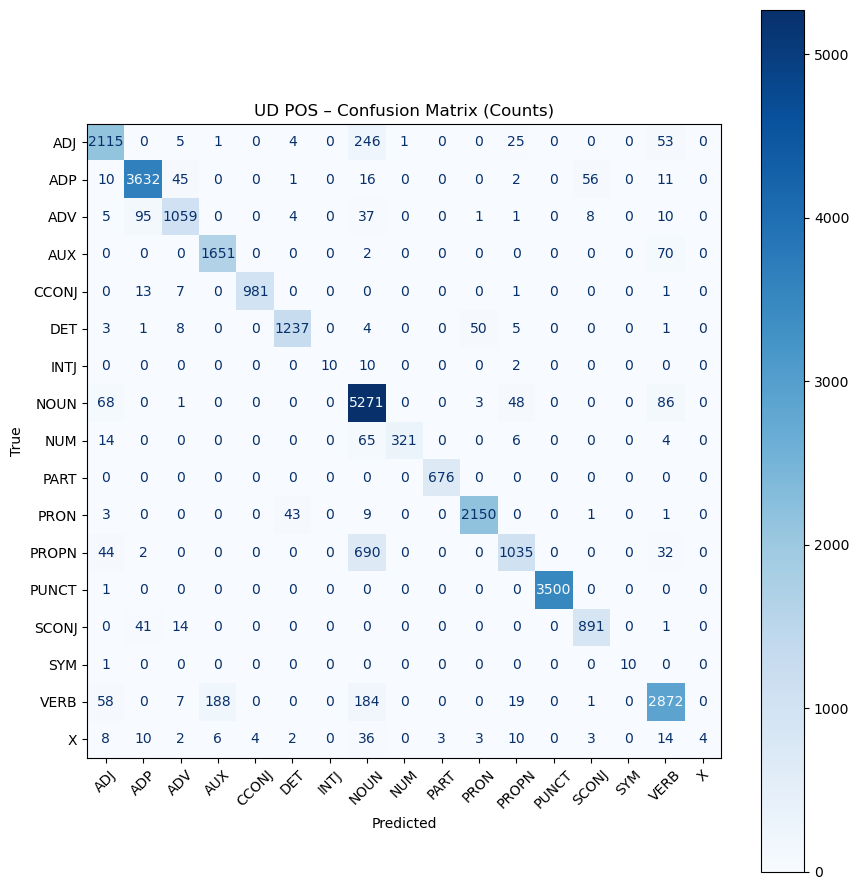

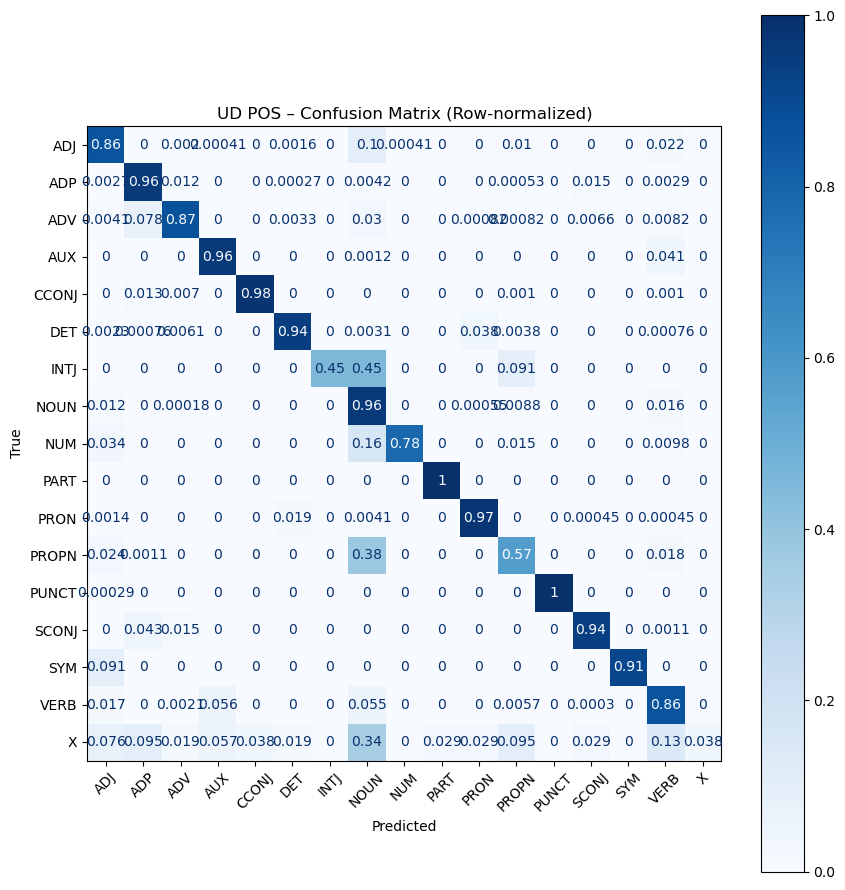


Top confusions by COUNT (true → predicted):
 PROPN → NOUN   : 690
   ADJ → NOUN   : 246
  VERB → AUX    : 188
  VERB → NOUN   : 184
   ADV → ADP    : 95
  NOUN → VERB   : 86
   AUX → VERB   : 70
  NOUN → ADJ    : 68
   NUM → NOUN   : 65
  VERB → ADJ    : 58

Top confusions by RATE (row-normalized, true → predicted):
  INTJ → NOUN   : 0.455
 PROPN → NOUN   : 0.383
     X → NOUN   : 0.343
   NUM → NOUN   : 0.159
     X → VERB   : 0.133
   ADJ → NOUN   : 0.100
     X → ADP    : 0.095
     X → PROPN  : 0.095
   SYM → ADJ    : 0.091
  INTJ → PROPN  : 0.091


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
# training the best model 
best_tagger = GreedyTagger(feature_function=context_features)
best_tagger.fit(train_data_x, train_data_y)

# prediction part
test_pred = best_tagger.predict_with_history(test_data_x)
test_acc = tagging_accuracy(test_data_y, test_pred)
print("Best model test accuracy:", test_acc)

# confusion matrix
y_true = [y for s in test_data_y for y in s]
y_pred = [y for s in test_pred   for y in s]
labels = sorted(set(y_true) | set(y_pred))

# counts
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(9, 9))
disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=45, colorbar=True)
ax.set_title("UD POS – Confusion Matrix (Counts)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# row-normalized (per true class)
cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
fig2, ax2 = plt.subplots(figsize=(9, 9))
disp2.plot(include_values=True, cmap="Blues", ax=ax2, xticks_rotation=45, colorbar=True)
ax2.set_title("UD POS – Confusion Matrix (Row-normalized)")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")
plt.tight_layout()
plt.show()

# 4) Print top confusions (by count and by rate)
N = 10

cm_off = cm.copy().astype(float)
np.fill_diagonal(cm_off, 0)
flat_idx = np.argsort(cm_off, axis=None)[::-1]
print("\nTop confusions by COUNT (true → predicted):")
printed = 0
for idx in flat_idx:
    if printed >= N: break
    i, j = divmod(idx, cm_off.shape[1])
    if cm_off[i, j] <= 0: break
    print(f"{labels[i]:>6} → {labels[j]:<6} : {int(cm_off[i, j])}")
    printed += 1

cm_off_norm = cm_norm.copy()
np.fill_diagonal(cm_off_norm, 0.0)
flat_idx2 = np.argsort(cm_off_norm, axis=None)[::-1]
print("\nTop confusions by RATE (row-normalized, true → predicted):")
printed = 0
for idx in flat_idx2:
    if printed >= N: break
    i, j = divmod(idx, cm_off_norm.shape[1])
    if cm_off_norm[i, j] <= 0: break
    print(f"{labels[i]:>6} → {labels[j]:<6} : {cm_off_norm[i, j]:.3f}")
    printed += 1

## Part 2 – Span identification with sequence models

In this part, you'll use the same sequence models for a different task: named entity recognition for English.

**Task 2.1** (0.5 point): Write the code to load the train and test data.

In [21]:
def load_ner_data(filename):
    # IMPLEMENT THE CODE TO LOAD THE NER DATA
    X, Y = [], []  # X = list of words, Y = list of tags
    sent_x, sent_y = [], []  # temporary lists for one sentence

    with open(filename) as f:   # open the file
        for line in f:  # iterate through lines in the file
            line = line.strip() # remove leading/trailing whitespace(including newlines)
            
            if not line: # if the line is blank, sentence boundary
                if sent_x: # only save if sentence is non empty
                    X.append(sent_x) # add collected words to dataset
                    Y.append(sent_y) # add collected tags to dataset
                    sent_x, sent_y = [], []   # reset for the next sentence
                continue             
            
            parts = line.split()  # split the line into columns
            if len(parts) >= 2:  # make sure there are at least 2 columns
                token, tag = parts[0], parts[-1]  # word = first column, tag = last column
                sent_x.append(token)  # add word to current sentence
                sent_y.append(tag) # add tag to current sentence

        # after file ends, check if there’s still an unfinished sentence
        if sent_x:
            X.append(sent_x) # add last sentence words
            Y.append(sent_y) # add last sentence tags

    return X, Y                      


# Load the training and test datasets
train_nerdata_x, train_nerdata_y = load_ner_data('ner-train.txt')
test_nerdata_x, test_nerdata_y   = load_ner_data('ner-test.txt')


**Task 2.2** (0.5 point): Train a greedy tagger with the NER training data. Use any feature set that worked well for POS tagging, but *do not include transition features* for now. Compute the token-level accuracy of the test set, as before.

In [24]:

ner_tagger = GreedyTagger(
    feature_function=context_features)
ner_tagger.fit(train_nerdata_x, train_nerdata_y) # train tagger on training data

test_pred_ner = ner_tagger.predict_with_history(test_nerdata_x) # predict tags for test set
test_acc_ner  = tagging_accuracy(test_nerdata_y, test_pred_ner) # compute token-level accuracy

print(test_acc_ner) # show result


0.9248703552907899


**Task 2.3** (1 point): Token-level accuracy is not well adapted to span identification tasks (why?). Instead, we want to compute precision, recall and f-score of the *entities*. Adapt the code below:

In [31]:
def get_ranges(l):
    """
    Helper procedure for eval_ner.
    You're not expected to change anything here.
    """
    elements = []
    current_element = None
    current_start = None
    for i, ll in enumerate(l):
        if ll == "O":
            if current_element != None:
                elements.append((current_element, current_start, i))
            current_element = None
            current_start = -1
        elif ll[0] == "B":
            if current_element != None:
                elements.append((current_element, current_start, i))
            current_element = ll[2:]
            current_start = i
        elif ll[0] == "I":
            if current_element != ll[2:]:
                elements.append((current_element, current_start, i))
                current_element = ll[2:]
                current_start = i
    return elements


def eval_ner(sys_labels, gold_labels):
    """
    Computes precision, recall and f1-score, using get_ranges() to identify the named entities.
    """
    tp, fp, fn = 0, 0, 0
    for sys_l, gold_l in zip(sys_labels, gold_labels):
        sys_ranges = get_ranges(sys_l)
        gold_ranges = get_ranges(gold_l)
        for r in sys_ranges:
            if r in gold_ranges:
                tp += 1
        ## TODO: also count fp and fn
        # false positives
        fp += len([r for r in sys_ranges if r not in gold_ranges])
        # false negatives
        fn += len([r for r in gold_ranges if r not in sys_ranges])

    
    ## TODO: compute recall, precision and f1-score from tp, fp and fn
    prec   = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1score = (2 * prec * recall) / (prec + recall) if (prec + recall) > 0 else 0.0

    return recall, prec, f1score

# predict the model and compute the rpecision, recall and f1
test_pred_ner = ner_tagger.predict_with_history(test_nerdata_x)

recall, precision, f1 = eval_ner(test_pred_ner, test_nerdata_y)
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1_score      : {f1:.4f}")


NER entity-level precision: 0.7079
NER entity-level recall   : 0.5440
NER entity-level F1       : 0.6152


Report precision, recall and f1-score of the model trained above.

The precision is 0.71, indicating a good reliability where around 71% of the predictions of the entities are correct. The recall is 0.54, which means that the model correctly predicted 54% of the gold entities, with almost half of them missing. And the f1 score is 0.62, suggesting an overall balanced performance between precision and recall. 

Token-level accuracy is not well adapted to span identification tasks, because it operates per token but doesn’t require exact span boundaries.


**Task 2.4** (1 point): Train a new model with transition features and predict the development set labels using `predict_with_history`. How does this change affect the token-level (accuracy) and entity-level (recall, precision, f1-score) metrics?

In [33]:
# define the dev data - not sure if can just use test?
dev_nerdata_x, dev_nerdata_y = test_nerdata_x, test_nerdata_y

# train and evaluate the transition features
trans_ner = GreedyTagger(  
    feature_function=transition_features)
trans_ner.fit(train_nerdata_x, train_nerdata_y)  # train the transition-feature tagger on the same NER training data
dev_pred_trans = trans_ner.predict_with_history(dev_nerdata_x)  # predicting BIO tags on the development set using greedy decoding that updates history
acc_trans = tagging_accuracy(dev_nerdata_y, dev_pred_trans)  #  token-level accuracy for the transitions model on the development set
rec_trans, prec_trans, f1_trans = eval_ner(dev_pred_trans, dev_nerdata_y)  #  entity-level recall, precision, and F1 for the transitions model

# train and evaluate baseline model 
baseline_ner = GreedyTagger(  
    feature_function=context_features)
baseline_ner.fit(train_nerdata_x, train_nerdata_y)  # train the baseline tagger on the NER training data
dev_pred_base = baseline_ner.predict_with_history(dev_nerdata_x)  # predict BIO tags on the development set using greedy decoding 
acc_base = tagging_accuracy(dev_nerdata_y, dev_pred_base)  # token-level accuracy for the baseline model on the development set
rec_base, prec_base, f1_base = eval_ner(dev_pred_base, dev_nerdata_y)  # entity-level recall, precision, and F1 for the baseline model

# results
print(f"Baseline (no transitions):  Acc={acc_base:.4f}  P={prec_base:.4f}  R={rec_base:.4f}  F1={f1_base:.4f}")  # This line prints the baseline model's token accuracy and entity metrics.
print(f"With transitions (prev):    Acc={acc_trans:.4f}  P={prec_trans:.4f}  R={rec_trans:.4f}  F1={f1_trans:.4f}")  # This line prints the transitions model's token accuracy and entity metrics.
print(f"trans - base:           Acc={acc_trans-acc_base:+.4f}  P={prec_trans-prec_base:+.4f}  R={rec_trans-rec_base:+.4f}  F1={f1_trans-f1_base:+.4f}")  # This line prints the metric differences to show the effect of adding transitions.

Baseline (no transitions):  Acc=0.9249  P=0.7079  R=0.5440  F1=0.6152
With transitions (prev):    Acc=0.9217  P=0.8690  R=0.5630  F1=0.6833
trans - base:           Acc=-0.0032  P=+0.1611  R=+0.0190  F1=+0.0681


Adding the transition features lowered the accuracy a bit, but increased the span quality signoificantly. 

**Task 2.5** (2 points): Take some 50 sentences from the test set and display the words, gold tags, and the predicted tags of the two systems. Can you identify error patterns that are typical for the two systems respectively?

In [ ]:
# train both systems
baseline_ner = GreedyTagger(feature_function=context_features) 
baseline_ner.fit(train_nerdata_x, train_nerdata_y)  

trans_ner = GreedyTagger(feature_function=transition_features)  
trans_ner.fit(train_nerdata_x, train_nerdata_y) 

# Choose 50 sentences from the test set 
indices = list(range(len(test_nerdata_x)))  # constructing a list of all sentence indices 
sample_ids = indices[:50]  # choosing the first 50 sentences 

# Get predictions from both systems on the selected sentences
sample_X = [test_nerdata_x[i] for i in sample_ids]  # collecting the words for the selected sentences prepares inputs for decoding
sample_gold = [test_nerdata_y[i] for i in sample_ids]  # collecting the gold BIO tags provides the reference labels for evaluation
pred_base = baseline_ner.predict_with_history(sample_X)  # decoding with the baseline model 
pred_trans = trans_ner.predict_with_history(sample_X)  # decoding with the transition model 

# Define a small printer that shows token, gold, baseline, transitions, and a mismatch marker.
def show_sentence(words, gold, base, trans, sid):
    print(f"\n===== Sentence {sid} (len={len(words)}) =====")  # printing a header clarifies sentence identity and length
    print(f"{'TOKEN':20} {'GOLD':10} {'BASE':10} {'TRANS':10} {'ERR?'}")  # printing column headers improves readability of the following rows
    for w, g, b, t in zip(words, gold, base, trans):  # iterating tokenwise over aligned sequences allows row-by-row comparison.
        mark = "" if (b == g and t == g) else ("B" if b != g and t == g else ("T" if t != g and b == g else ("B,T" if (b != g and t != g) else "")))  # computing a marker indicates which system(s) are incorrect on this token.
        print(f"{w[:20]:20} {g:10} {b:10} {t:10} {mark}")  # printing each row shows the token and tags with a concise error marker

# Print all 50 sentences with aligned tags
for rank, i in enumerate(sample_ids, start=1):  # enumerating chosen indices 
    words = sample_X[rank-1]  # selecting the words by rank accesses the pre-sliced sentence efficiently
    gold  = sample_gold[rank-1]  # selecting the gold tags by rank keeps the sequences aligned with the words
    base  = pred_base[rank-1]  # selecting the baseline predictions by rank keeps alignment consistent
    tran  = pred_trans[rank-1]  # selecting the transitions predictions by rank completes the four aligned sequences
    assert len(words) == len(gold) == len(base) == len(tran), "Detected a length mismatch within a sentence."  # verifying equal lengths prevents misaligned printing
    show_sentence(words, gold, base, tran, sid=i)  # calling the printer produces a clear side-by-side comparison for this sentence



## Part 3: Text classification with feed-forward neural networks

For this part, we go back to the text classification task used in the first assignment: language identification of Bokmål and Nynorsk.

Instead of manually creating a bag-of-subwords matrix with the BPE-encoded data, we go a simpler route this time and use the `CountVectorizer` class provided by Scikit-Learn. Have a look at the documentation of `CountVectorizer` here: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

With the default parameters, `CountVectorizer` will tokenize the data at whitespaces, remove punctuation signs and convert everything to lowercase. You can play around with the parameters if you wish, but the default settings work decently well. A useful thing to make the vectors smaller is to remove hapaxes, i.e. words that occur only once in the training data. You can achieve this with `min_df=2`.

**Task 3.1** (2 points): Write the code to produce `train_X, train_Y, test_X, test_Y`. Each `*_X` variable should contain a list of vectors produced by `CountVectorizer`. Each `*_Y` variable should contain a list of integers (1 for Nynorsk and 0 for Bokmål).

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=2)

**Task 3.2** (1 point): Create a logistic regression classifier, train it on the training set, and predict the labels of the test set. Compute accuracy, precision and recall, as in the previous assignment. How do your results compare with the previous assignment?

**Task 3.3** (1 point): Let us use a simple feed-forward neural network classifier instead of logistic regression, but keep the input feature representation identical. Scikit-Learn provides a simple feed-forward classifier under the name `MLPClassifier`. The most important parameter is `hidden_layer_sizes`, which specifies the number and size of hidden layers. For example, `MLPClassifier(hidden_layer_sizes=(10, 5))` creates a classifier with two hidden layers, the first one with 10 neurons and the second one with 5 neurons. To start, keep the model simple and choose a single hidden layer with 10 neurons. How does this model perform in comparison with logistic regression?

In [ ]:
from sklearn.neural_network import MLPClassifier

**Task 3.4** (1 point): Try to improve the results by adding more and/or larger hidden layers. You're not expected to work with more than 50 neurons in total, as this slows down the training process drastically.

Now, let us see if we can improve the input representation. Instead of a bag-of-words model created with `CountVectorizer`, we will obtain document embeddings from a pretrained Norwegian SentenceBert model (in particular, the [base model from the National Library of Norway](https://huggingface.co/NbAiLab/nb-sbert-base)). The following snippet shows how to load and use such a model.

In [ ]:
from sentence_transformers import SentenceTransformer

# Uncomment the corresponding line:

# model = SentenceTransformer('NbAiLab/nb-sbert-base') # if you use your own environment

# model = SentenceTransformer("NbAiLab/nb-sbert-base", cache_folder="/fp/projects01/ec403/hf_models") # if you use Fox

sentences = [
    "This is a Norwegian boy",
    "Dette er en norsk gutt",
    "Dette er ein norsk gut",
]
embeddings = model.encode(sentences)
print(embeddings)

**Task 3.5** (1 point): Produce embeddings for the training and test sets and train a new `MLPClassifier` with these embeddings as input features. Can you further improve the evaluation scores?

Note: Producing the embeddings and training the model will take longer than in previous exercises, around 10 minutes.